In [1]:
import io
import math
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import matplotlib.pyplot as plt

# from tqdm import tqdm
from tqdm.notebook import tqdm
from time import sleep
from timeit import default_timer as timer

data = pd.read_csv('./data/rev_train_32.csv', header=None, sep=';')
test_data = pd.read_csv('./data/rev_val_32.csv', header=None, sep=';')

In [2]:
class ReverseStringsDataset(Dataset):
    def __init__(self, data):
        super(self.__class__, self).__init__()
        self.inputs = data[0].values
        self.outputs = data[1].values
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx].strip(), self.outputs[idx].strip()
    
dataset = ReverseStringsDataset(data)

def yield_tokens(dataset):
    for i in range(len(dataset)):
        yield dataset[i][0].strip().split() + dataset[i][1].strip().split()        
        
vocab = build_vocab_from_iterator(yield_tokens(dataset), 
                                      specials=['<unk>', '<pad>', '<start>', '<eos>'],
                                      special_first=True)
print("vocabulary", len(vocab))
vocab.get_stoi()

vocabulary 14


{'b': 12,
 'e': 11,
 'j': 4,
 '<unk>': 0,
 '<start>': 2,
 '<pad>': 1,
 'i': 6,
 'h': 13,
 'd': 5,
 'a': 9,
 'g': 7,
 'f': 10,
 '<eos>': 3,
 'c': 8}

In [3]:
def vocab_func(vocab):
    def func(tok_iter):
        return [vocab[tok] for tok in tok_iter]
    return func

start_idx = vocab['<start>']
eos_idx = vocab['<eos>']
pad_idx = vocab['<pad>']

def totensor(dtype):
    def func(ids_list):
        return torch.cat((torch.tensor([start_idx]).to(dtype), 
                          torch.tensor(ids_list).to(dtype), 
                          torch.tensor([eos_idx]).to(dtype)))  
    return func    

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

transforms = sequential_transforms(lambda x: x.split(), vocab_func(vocab), totensor(torch.long))

# emb_size = len(vocab)
emb_size = 16
batch_size = 32
tgt_vocab_size = len(vocab)

# function to collate data samples into batch tesors
def collate_fn(batch):
    input_batch, output_batch = [], []
    for i, o in batch:
#         input_batch.append(torch.nn.functional.one_hot(transforms(i), num_classes=emb_size))
#         output_batch.append(torch.nn.functional.one_hot(transforms(o), num_classes=emb_size))
        input_batch.append(transforms(i))
        output_batch.append(transforms(o))
        
    input_batch = pad_sequence(input_batch, padding_value=pad_idx)
    output_batch = pad_sequence(output_batch, padding_value=pad_idx)
    return input_batch, output_batch

dataset = ReverseStringsDataset(data)
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
next(iter(train_dataloader))

(tensor([[ 2,  2,  2,  ...,  2,  2,  2],
         [ 9,  5, 12,  ..., 12, 10, 10],
         [10,  6,  7,  ..., 11,  5,  4],
         ...,
         [ 4,  8,  5,  ...,  7,  8,  4],
         [ 5, 13,  5,  ..., 13, 11, 11],
         [ 3,  3,  3,  ...,  3,  3,  3]]),
 tensor([[ 2,  2,  2,  ...,  2,  2,  2],
         [ 5, 13,  5,  ..., 13, 11, 11],
         [ 4,  8,  5,  ...,  7,  8,  4],
         ...,
         [10,  6,  7,  ..., 11,  5,  4],
         [ 9,  5, 12,  ..., 12, 10, 10],
         [ 3,  3,  3,  ...,  3,  3,  3]]))

torch.Size([500, 16])


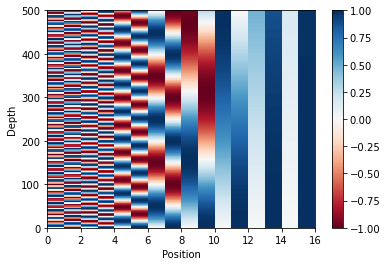

In [4]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 500):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token: Tensor):
        token_embedding = torch.nn.functional.one_hot(token, num_classes=emb_size)
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

pe = PositionalEncoding(emb_size, dropout=0.1)
img = pe.pos_embedding.permute(1,0,2).squeeze()
print(img.shape)

plt.pcolormesh(img, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Seq2SeqTransformer(nn.Module):
    def __init__(self, emb_size: int, tgt_vocab_size):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=emb_size)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.positional_encoding = PositionalEncoding(emb_size)

    def forward(self,
                src: Tensor,
                tgt: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(src)
        tgt_emb = self.positional_encoding(tgt)
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(src), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(tgt), memory, tgt_mask)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == pad_idx).transpose(0, 1)
    tgt_padding_mask = (tgt == pad_idx).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

transformer = Seq2SeqTransformer(emb_size, tgt_vocab_size)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

# optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001)

In [6]:
def train_epoch(model, optimizer, epoch):
    model.train()
    losses = 0

    dataset = ReverseStringsDataset(data)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    i = 0
    
    with tqdm(train_dataloader, unit="batch") as tepoch:

        tepoch.set_description(f"Epoch {epoch}")
        
        for src, tgt in tepoch:
            src = src.to(device)
            tgt = tgt.to(device)
            
            tgt_input = tgt[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

            optimizer.zero_grad()

            tgt_out = tgt[1:, :]
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            loss.backward()

            optimizer.step()
            losses += loss.item()

            i += 1
            tepoch.set_postfix(loss=(losses / i))

    return losses / len(train_dataloader)

def evaluate(model):
    model.eval()
    losses = 0

    dataset = ReverseStringsDataset(test_data)
    val_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == eos_idx:
            break
    return ys

# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = transforms(src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=start_idx).flatten()
    return " ".join(vocab.lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<start>", "").replace("<eos>", "").strip()

In [7]:
test_dataset = ReverseStringsDataset(test_data)

for epoch in range(1, 100):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, epoch)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
    input = test_dataset[0][0]
    output = test_dataset[0][1]
    prediction = translate(transformer, input)
    print("input")
    print(input)
    print("output")
    print(output)
    print("prediction")
    print(prediction)
    print(output == prediction, len(output), len(prediction))
    
    from timeit import default_timer as timer

# for epoch in range(1, 50):
#     start_time = timer()
#     train_loss = train_epoch(transformer, optimizer, epoch)
#     end_time = timer()
#     val_loss = evaluate(transformer)
#     print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 1, Train loss: 2.399, Val loss: 2.276, Epoch time = 12.357s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
a a a a a a a a a a a a a a c c a a a c c a a a a a a a a a a e
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 2, Train loss: 2.279, Val loss: 2.240, Epoch time = 12.240s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 3, Train loss: 2.239, Val loss: 2.193, Epoch time = 11.962s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 4, Train loss: 2.209, Val loss: 2.166, Epoch time = 12.011s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 5, Train loss: 2.189, Val loss: 2.148, Epoch time = 12.040s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 6, Train loss: 2.172, Val loss: 2.131, Epoch time = 12.061s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 7, Train loss: 2.159, Val loss: 2.120, Epoch time = 12.029s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 8, Train loss: 2.148, Val loss: 2.113, Epoch time = 12.011s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 9, Train loss: 2.142, Val loss: 2.106, Epoch time = 11.969s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 10, Train loss: 2.136, Val loss: 2.102, Epoch time = 11.974s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 11, Train loss: 2.131, Val loss: 2.094, Epoch time = 12.067s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 12, Train loss: 2.122, Val loss: 2.069, Epoch time = 11.974s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b i b i b b b i b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 13, Train loss: 2.102, Val loss: 2.026, Epoch time = 11.948s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b b b b b i b i b a b a b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 14, Train loss: 2.075, Val loss: 1.983, Epoch time = 12.059s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b b b b b i b i b i b i b i b i b b b b b b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 15, Train loss: 2.048, Val loss: 1.931, Epoch time = 12.118s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b g b g b g b b b i b i b i b i b b a b a b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 16, Train loss: 2.013, Val loss: 1.864, Epoch time = 12.085s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b g b g b g b g b i b i b b b b d b d b i b a b b b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 17, Train loss: 1.975, Val loss: 1.801, Epoch time = 11.998s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
b b b b b g b g b g b b b b b d b d b d b a a a a b g b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 18, Train loss: 1.935, Val loss: 1.735, Epoch time = 11.969s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c g c g c g b g c g b d b d b d b d b d b a a a a b g b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 19, Train loss: 1.895, Val loss: 1.655, Epoch time = 12.014s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b b c g b g c g b i b i b b d b d b d a a a b g b g b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 20, Train loss: 1.846, Val loss: 1.556, Epoch time = 11.980s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c g c g c g b i i b i b d b d b d b d a a a b i b g b b b b b
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 21, Train loss: 1.791, Val loss: 1.453, Epoch time = 12.002s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c g c g c g b i i i i i b b b d b d a a a a i b i b b b b b j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 22, Train loss: 1.735, Val loss: 1.359, Epoch time = 12.058s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c f c g c b i i i i i b i b b d b d a a a a i i g b b b b j j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 23, Train loss: 1.681, Val loss: 1.263, Epoch time = 12.009s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c b c g b i i i i i i g b b d b d a a a a i i g b b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 24, Train loss: 1.624, Val loss: 1.180, Epoch time = 12.070s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f g g g i i i i i b g b b b d b a a a a i b f b g b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 25, Train loss: 1.567, Val loss: 1.095, Epoch time = 12.018s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f g g i b i i i i i b g b b d b a d a a b i g b b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 26, Train loss: 1.517, Val loss: 1.023, Epoch time = 12.013s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f g g j i b i i i i b g b d b d a a a a b i f b b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 27, Train loss: 1.467, Val loss: 0.947, Epoch time = 12.072s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f g j g b i i i i g b b b d b d a a a a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 28, Train loss: 1.417, Val loss: 0.871, Epoch time = 11.950s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f g g j i b i i i i g b b d b d a h a a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 29, Train loss: 1.367, Val loss: 0.798, Epoch time = 12.113s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f g g j i b i i i i g b b d b d a h a a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 30, Train loss: 1.321, Val loss: 0.741, Epoch time = 12.054s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f g g j i b i i i g b b b f d b a h a a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 31, Train loss: 1.278, Val loss: 0.699, Epoch time = 12.068s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c f a g j g i b i i i g b b b d b d a d a b a i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 32, Train loss: 1.234, Val loss: 0.636, Epoch time = 12.053s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f a g j i b e i i i g b b d b d a d a a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 33, Train loss: 1.189, Val loss: 0.561, Epoch time = 12.048s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f g j j i b i e i i g b b f d b a h a b a i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 34, Train loss: 1.147, Val loss: 0.518, Epoch time = 12.067s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f a g j i b e i i i b b b f d b a h d a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 35, Train loss: 1.110, Val loss: 0.452, Epoch time = 12.070s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e i i i g b b f d b a h d a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 36, Train loss: 1.071, Val loss: 0.445, Epoch time = 12.018s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c c c f a g j i b e i i i g b b f d b a h d a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 37, Train loss: 1.037, Val loss: 0.379, Epoch time = 11.984s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e i i i g b b f d b a h d a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 38, Train loss: 1.005, Val loss: 0.345, Epoch time = 12.147s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e i i i g b b f d b a h d a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 39, Train loss: 0.970, Val loss: 0.309, Epoch time = 12.175s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e i i i g b b f d b a h d a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 40, Train loss: 0.945, Val loss: 0.279, Epoch time = 12.109s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 41, Train loss: 0.913, Val loss: 0.250, Epoch time = 12.082s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e i i i g b b f d b a h d a b i f g b b b a j
False 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 42, Train loss: 0.888, Val loss: 0.225, Epoch time = 12.050s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 43, Train loss: 0.860, Val loss: 0.227, Epoch time = 12.082s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 44, Train loss: 0.832, Val loss: 0.167, Epoch time = 12.021s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 45, Train loss: 0.810, Val loss: 0.152, Epoch time = 12.163s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 46, Train loss: 0.789, Val loss: 0.149, Epoch time = 12.098s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 47, Train loss: 0.767, Val loss: 0.128, Epoch time = 12.147s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 48, Train loss: 0.745, Val loss: 0.104, Epoch time = 12.165s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 49, Train loss: 0.723, Val loss: 0.098, Epoch time = 12.114s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 50, Train loss: 0.704, Val loss: 0.091, Epoch time = 12.085s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 51, Train loss: 0.686, Val loss: 0.082, Epoch time = 12.130s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 52, Train loss: 0.670, Val loss: 0.070, Epoch time = 12.585s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 53, Train loss: 0.656, Val loss: 0.068, Epoch time = 12.618s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 54, Train loss: 0.640, Val loss: 0.059, Epoch time = 12.584s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 55, Train loss: 0.627, Val loss: 0.060, Epoch time = 12.349s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 56, Train loss: 0.617, Val loss: 0.048, Epoch time = 15.672s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 57, Train loss: 0.599, Val loss: 0.050, Epoch time = 22.083s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 58, Train loss: 0.585, Val loss: 0.043, Epoch time = 22.089s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 59, Train loss: 0.575, Val loss: 0.041, Epoch time = 21.714s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 60, Train loss: 0.562, Val loss: 0.041, Epoch time = 31.701s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 61, Train loss: 0.552, Val loss: 0.033, Epoch time = 33.945s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 62, Train loss: 0.540, Val loss: 0.034, Epoch time = 34.204s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 63, Train loss: 0.527, Val loss: 0.029, Epoch time = 33.082s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 64, Train loss: 0.521, Val loss: 0.027, Epoch time = 33.440s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 65, Train loss: 0.510, Val loss: 0.025, Epoch time = 33.364s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 66, Train loss: 0.502, Val loss: 0.024, Epoch time = 32.591s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 67, Train loss: 0.493, Val loss: 0.023, Epoch time = 32.434s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 68, Train loss: 0.487, Val loss: 0.022, Epoch time = 33.457s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 69, Train loss: 0.477, Val loss: 0.022, Epoch time = 32.425s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 70, Train loss: 0.470, Val loss: 0.020, Epoch time = 32.377s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 71, Train loss: 0.459, Val loss: 0.018, Epoch time = 32.597s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 72, Train loss: 0.455, Val loss: 0.021, Epoch time = 32.487s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 73, Train loss: 0.452, Val loss: 0.018, Epoch time = 32.230s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 74, Train loss: 0.439, Val loss: 0.016, Epoch time = 32.624s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 75, Train loss: 0.429, Val loss: 0.015, Epoch time = 32.540s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 76, Train loss: 0.426, Val loss: 0.014, Epoch time = 32.323s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 77, Train loss: 0.422, Val loss: 0.014, Epoch time = 33.148s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 78, Train loss: 0.415, Val loss: 0.014, Epoch time = 32.323s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 79, Train loss: 0.409, Val loss: 0.015, Epoch time = 32.965s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 80, Train loss: 0.405, Val loss: 0.012, Epoch time = 32.591s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 81, Train loss: 0.399, Val loss: 0.013, Epoch time = 32.415s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 82, Train loss: 0.390, Val loss: 0.011, Epoch time = 32.524s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 83, Train loss: 0.388, Val loss: 0.011, Epoch time = 32.226s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 84, Train loss: 0.383, Val loss: 0.011, Epoch time = 32.391s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 85, Train loss: 0.379, Val loss: 0.011, Epoch time = 32.645s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 86, Train loss: 0.377, Val loss: 0.010, Epoch time = 32.532s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 87, Train loss: 0.372, Val loss: 0.010, Epoch time = 32.246s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 88, Train loss: 0.367, Val loss: 0.009, Epoch time = 32.602s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 89, Train loss: 0.360, Val loss: 0.009, Epoch time = 32.484s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 90, Train loss: 0.356, Val loss: 0.010, Epoch time = 32.242s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 91, Train loss: 0.356, Val loss: 0.008, Epoch time = 32.592s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 92, Train loss: 0.346, Val loss: 0.008, Epoch time = 32.378s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 93, Train loss: 0.347, Val loss: 0.009, Epoch time = 32.567s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 94, Train loss: 0.342, Val loss: 0.008, Epoch time = 32.474s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 95, Train loss: 0.338, Val loss: 0.008, Epoch time = 32.452s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 96, Train loss: 0.336, Val loss: 0.009, Epoch time = 32.593s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 97, Train loss: 0.330, Val loss: 0.008, Epoch time = 32.517s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 98, Train loss: 0.328, Val loss: 0.008, Epoch time = 33.171s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch: 99, Train loss: 0.327, Val loss: 0.007, Epoch time = 32.747s
input
j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
prediction
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63


In [8]:
dataset = ReverseStringsDataset(test_data)
print(dataset[0][0])
output = dataset[0][1]
prediction = translate(transformer, dataset[0][0])
print("output")
print(output)
print(prediction)
print(output == prediction, len(output), len(prediction))

j a b b b g f i b a d h a b d f b b g i i d e b i j g a f c b c
output
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
c b c f a g j i b e d i i g b b f d b a h d a b i f g b b b a j
True 63 63
